# Analysis of the Autogluon results

##### Imports

In [194]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tabulate import tabulate

In [195]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Create Summaries

In [196]:
df_all = pd.DataFrame(columns=['Dataset', 'Type', 'Method', 'Value'])   
eval_files = sorted(os.listdir('evaldict'))

for eval_file in eval_files:
    core_name = eval_file[:-len('.parquet')]
    print(core_name)
    parts = core_name.split('_')
    method = parts[-1]
    parts.remove(method)
    parts.remove(parts[0])
    task_hint = parts[0]
    parts.remove(parts[0])
    dataset = '_'.join(parts)
    eval_df = pd.read_parquet('evaldict/' + eval_file)
    
    if task_hint == "regression":
        try:
            rmse = (- eval_df["root_mean_squared_error"]).tolist()
            value = np.average(rmse)
        except KeyError:
            value = np.nan
        df_all = df_all._append({'Dataset': dataset, 'Type': 'regression', 'Method': method, 'Value': value}, ignore_index=True)
    elif task_hint == "binary-classification":
        try:
            roc_auc = (- eval_df["roc_auc"]).tolist()
            value = np.average(roc_auc)
        except KeyError:
            value = np.nan
        df_all = df_all._append({'Dataset': dataset, 'Type': 'binary', 'Method': method, 'Value': value},ignore_index=True)
    elif task_hint == "multiclass":
        try:
            log_loss = (- eval_df["log_loss"]).tolist()
            value = np.average(log_loss)
        except KeyError:
            value = np.nan
        df_all = df_all._append({'Dataset': dataset, 'Type': 'multiclass', 'Method': method, 'Value': value},ignore_index=True)
print(df_all)

evaldict_binary-classification_APSFailure_autofeat
evaldict_binary-classification_APSFailure_bioautoml
evaldict_binary-classification_APSFailure_correlationbased
evaldict_binary-classification_APSFailure_featuretools
evaldict_binary-classification_APSFailure_macfe
evaldict_binary-classification_APSFailure_nfs
evaldict_binary-classification_APSFailure_openfe
evaldict_binary-classification_Amazon_employee_access_correlationbased
evaldict_binary-classification_Amazon_employee_access_featuretools
evaldict_binary-classification_Amazon_employee_access_macfe
evaldict_binary-classification_Amazon_employee_access_mafese
evaldict_binary-classification_Amazon_employee_access_nfs
evaldict_binary-classification_Australian_correlationbased
evaldict_binary-classification_Australian_featuretools
evaldict_binary-classification_Australian_macfe
evaldict_binary-classification_Australian_mafese
evaldict_binary-classification_Australian_nfs
evaldict_binary-classification_Bioresponse_correlationbased
evaldi

##### Add Std Deviation

In [197]:
df_stddev = df_all.groupby(['Dataset', 'Type', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Type', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

        Dataset    Type            Method  Value
0    APSFailure  binary          autofeat    0.0
1    APSFailure  binary         bioautoml    0.0
2    APSFailure  binary  correlationbased    0.0
3    APSFailure  binary      featuretools    0.0
4    APSFailure  binary             macfe    0.0
..          ...     ...               ...    ...
685       yeast  binary  correlationbased    0.0
686       yeast  binary      featuretools    0.0
687       yeast  binary             macfe    0.0
688       yeast  binary            mafese    0.0
689       yeast  binary               nfs    0.0

[690 rows x 4 columns]


In [198]:
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

        Dataset    Type            Method  Value  StdDev Value_with_StdDev
0    APSFailure  binary          autofeat    0.0     0.0         0.0 ± 0.0
1    APSFailure  binary         bioautoml    0.0     0.0         0.0 ± 0.0
2    APSFailure  binary  correlationbased    0.0     0.0         0.0 ± 0.0
3    APSFailure  binary      featuretools    0.0     0.0         0.0 ± 0.0
4    APSFailure  binary             macfe    0.0     0.0         0.0 ± 0.0
..          ...     ...               ...    ...     ...               ...
685       yeast  binary  correlationbased    0.0     0.0         0.0 ± 0.0
686       yeast  binary      featuretools    0.0     0.0         0.0 ± 0.0
687       yeast  binary             macfe    0.0     0.0         0.0 ± 0.0
688       yeast  binary            mafese    0.0     0.0         0.0 ± 0.0
689       yeast  binary               nfs    0.0     0.0         0.0 ± 0.0

[690 rows x 6 columns]


In [199]:
# Print and write to file
pivot_table = df_summary.pivot(index=['Dataset', 'Type'], columns=['Method'], values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('evaldict.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+-----+----------------------------------------+------------+---------------------------+---------------------------+---------------------------+--------------------------+------------------+--------------+----------------------------+-----------+-----------+-----------+---------------------------+-----------+-----------------------------+---------------------------+
|     |                Dataset                 |    Type    |         autofeat          |         autogluon         |         bioautoml         |          boruta          | correlationbased | featuretools |         featurewiz         |     h     |   macfe   |  mafese   |           mljar           |    nfs    |           openfe            |         original          |
+-----+----------------------------------------+------------+---------------------------+---------------------------+---------------------------+--------------------------+------------------+--------------+----------------------------+-----------+-----------+-

In [200]:
# Print and write to file
pivot_table = df_summary.pivot(index=['Dataset', 'Type'], columns=['Method'], values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
regression_table = pd.DataFrame()
binary_table = pd.DataFrame()
multiclass_table = pd.DataFrame()
index = 0
for row in pivot_table.iterrows():
    print(pd.DataFrame(row))
    if row[1][1] == 'regression':
        regression_table._append(pd.Series(row), ignore_index=True)
    elif row[1][1] == 'binary':
        binary_table._append(pd.Series(row), ignore_index=True)
    elif row[1][1] == 'multiclass':
        multiclass_table._append(pd.Series(row), ignore_index=True)
    index += 1
regression_table.to_parquet('evaldict_regression.parquet')
binary_table.to_parquet('evaldict_binary_classification.parquet')
multiclass_table.to_parquet('evaldict_multiclass.parquet')
print(tabulate(regression_table, headers='keys', tablefmt='pretty'))
print(tabulate(binary_table, headers='keys', tablefmt='pretty'))
print(tabulate(multiclass_table, headers='keys', tablefmt='pretty'))

                                                   0
0                                                  0
1  Method
Dataset             APSFailure
Type    ...
                                                   0
0                                                  1
1  Method
Dataset             Airlines_DepDelay_1...
                                                   0
0                                                  2
1  Method
Dataset             Allstate_Claims_Sev...
                                                   0
0                                                  3
1  Method
Dataset             Amazon_employee_acc...
                                                   0
0                                                  4
1  Method
Dataset             Australian
Type    ...
                                                   0
0                                                  5
1  Method
Dataset             Bioresponse
Type   ...
                                              

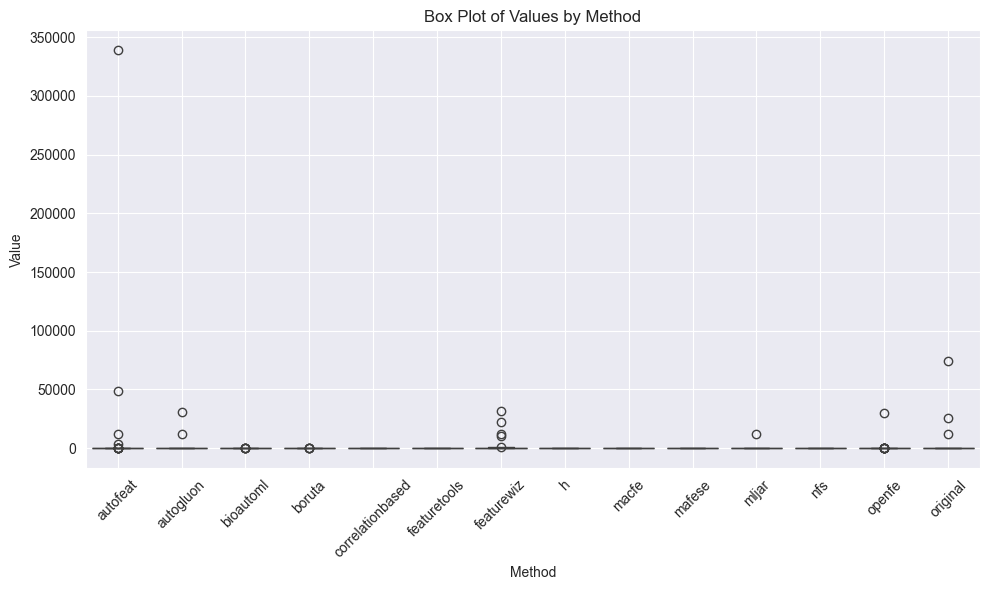

In [201]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset', 'Type'], var_name='Method', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Value', data=melted_df)
plt.xlabel("Method")
plt.ylabel("Value")
plt.title("Box Plot of Values by Method")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()